In [1]:
import pandas as pd
import numpy as np
import time as time
import pickle
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import random
import networkx as nx
from sklearn.metrics import classification_report

In [2]:
datadir = "data/pubmed"
max_groupsize = 131
min_groupsize = 1
num_categories = 3

In [3]:
G = nx.read_edgelist(datadir+"/Pubmed-Diabetes.DIRECTED.cites.tab", nodetype=str, create_using=nx.DiGraph()) # must be in edgelist (node1 node2\n) format

In [4]:
classes = {}
with open(datadir+"/Pubmed-Diabetes.NODE.paper.tab") as f:
    content = f.readlines()
    
for line in content:
    split = line.split(",")
    key = split[0]
    val_label = split[1]
    val = val_label.split("=")[1]    
    classes[str(key)] = str(val)

In [5]:
hyperedges = {}
nodes = G.nodes
max_size = 0
min_size = 100000
for node in nodes:
    neighborhood = list(G.neighbors(node))
    if len(neighborhood)+1 <= max_groupsize and len(neighborhood)+1 >= min_groupsize:
        hyperedges[node] = {}
        hyperedges[node]["members"] = []
        hyperedges[node]["members"].append(node)
        hyperedges[node]["category"] = classes[node]
        for neighbor in neighborhood:
            hyperedges[node]["members"].append(neighbor)
    if len(neighborhood)+1 < min_size:
        min_size = len(neighborhood)+1
    if len(neighborhood) > max_size:
        max_size = len(neighborhood)+1
print(min_size, max_size)
print(len(hyperedges))

1 131
19717


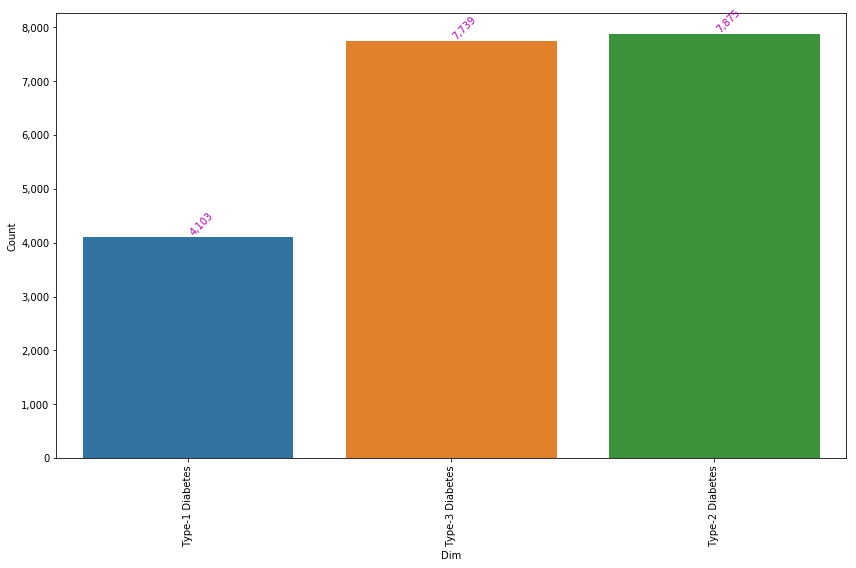

In [6]:
cat_amounts = {}
cat_names = {"1":"Type-1 Diabetes","2":"Type-2 Diabetes","3":"Type-3 Diabetes"}

for h in hyperedges:
    if cat_names[str(hyperedges[h]["category"])] not in cat_amounts:
        cat_amounts[cat_names[str(hyperedges[h]["category"])]]=1
    else:
        cat_amounts[cat_names[str(hyperedges[h]["category"])]]+=1


pd_df = pd.DataFrame(list(cat_amounts.items()))
pd_df.columns =["Dim","Count"]
# sort df by Count column
pd_df = pd_df.sort_values(['Count']).reset_index(drop=True)

plt.figure(figsize=(12,8))
# plot barh chart with index as x values
ax = sns.barplot(pd_df.index, pd_df.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Dim", ylabel='Count')
# add proper Dim values as x labels
ax.set_xticklabels(pd_df.Dim)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(pd_df["Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

In [7]:
vertexMemberships = {}
for h_index in hyperedges:
    hyperedge = hyperedges[h_index]
    authors = hyperedge["members"]
    for author in authors:
        if author in vertexMemberships:
            vertexMemberships[author].append(h_index)
        else:
            authorMembershipList = []
            authorMembershipList.append(h_index)
            vertexMemberships[author] = authorMembershipList

In [8]:
print(len(hyperedges))
print(len(vertexMemberships))
with open(datadir+'/hyperedges.p', 'wb') as fp:
    pickle.dump(hyperedges, fp)
with open(datadir+'/vertexMemberships.p', 'wb') as fp:
    pickle.dump(vertexMemberships, fp)

19717
19717


In [ ]:
from HypergraphRandomWalks import SubsampleAndTraverse

walksSAT = SubsampleAndTraverse(length=50, 
                                   num_walks=50, 
                                   hyperedges=hyperedges, 
                                   vertexMemberships=vertexMemberships,
                                   p_traverse_method="inverse",
                                   p_traverse=0.15, 
                                   p_traverse_initial=0.1)

In [ ]:
from HypergraphRandomWalks import TraverseAndSelect

walksTAS = TraverseAndSelect(length=50, 
                               num_walks=50, 
                               hyperedges=hyperedges, 
                               vertexMemberships=vertexMemberships,
                               p_select_method="inverse",
                               p_select=0.15, 
                               p_select_initial=0.1)

In [ ]:
with open(datadir+'/walksSAT.p', 'wb') as fp:
    pickle.dump(walksSAT, fp)

with open(datadir+'/walksTAS.p', 'wb') as fp:
    pickle.dump(walksTAS, fp)

In [ ]:
from Embeddings import EmbedWord2Vec

vertex_embedding_dimension = 16
hyperedge_embedding_dimension = 128

vertex_ids, vertex_embeddings = EmbedWord2Vec(walks=walksSAT,dimension=vertex_embedding_dimension)
print("Vertex embeddings finished.")
hyperedge_ids, hyperedge_embeddings = EmbedWord2Vec(walks=walksTAS,dimension=hyperedge_embedding_dimension)
print("Hyperedge embeddings finished.")

Creating embeddings.
Embedding generation runtime:  3016.8408851623535
Vertex embeddings finished.
Creating embeddings.


In [ ]:
print(len(vertex_embeddings))
with open(datadir+'/vertex_embeddings_'+str(max_groupsize)+'.p', 'wb') as fp:
    pickle.dump(vertex_embeddings, fp)
print(len(hyperedge_embeddings))
with open(datadir+'/hyperedge_embeddings_'+str(max_groupsize)+'.p', 'wb') as fp:
    pickle.dump(hyperedge_embeddings, fp)

In [ ]:
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualizeTSNE(embeddings,obj,with_labels=None,ids=None):
    targets = None
    transform = TSNE
    trans = transform(n_components=2)
    embeddings_2d = trans.fit_transform(embeddings)

    alpha = 0.7
    plt.figure(figsize=(7,7))
    plt.axes().set(aspect="equal")
    
    if with_labels:
        targets = [int(with_labels[identifier]['category'])-1 for identifier in ids]
        cmap = cm.rainbow(np.linspace(0.0, 1.0, num_categories))
        colors = cmap[targets]
        
        plt.scatter(embeddings_2d[:,0], 
                    embeddings_2d[:,1], 
                    cmap="jet", c=colors, alpha=alpha)
    else:
        plt.scatter(embeddings_2d[:,0], 
                    embeddings_2d[:,1], 
                    cmap="jet", alpha=alpha)
    
    plt.title('TSNE visualization of '+obj+' embeddings in the hypergraph.'.format(transform.__name__))
    plt.show()
    return targets
targets = visualizeTSNE(vertex_embeddings,"vertex")
targets = visualizeTSNE(hyperedge_embeddings,"hyperedge",hyperedges,hyperedge_ids)

In [ ]:
def getTrainingData():
    i = 0
    lists = []
    labels = []
    maxi = 0
    for h in hyperedges:
        
        vertex_embedding_list = []
        hyperedge = hyperedges[h]
        for vertex in hyperedge["members"]:
            i+=1
            if i%100000==0:
                print(i)
            try: # Good ol' nondeterminism
                vertex_embedding_list.append(vertex_embeddings[vertex_ids.index(vertex)].tolist())
            except:
                print("Missed one: ",vertex)
        lists.append({"v":vertex_embedding_list,"h":hyperedge_embeddings[hyperedge_ids.index(h)].tolist()})
        label = np.zeros((num_categories,))
        label[int(hyperedge["category"])-1] = 1
        labels.append(label)
    X_unshuffled = []
    
    for hlist in lists:
        np_vertex_embeddings = np.asarray(hlist["v"])
        x = np.zeros((hyperedge_embedding_dimension + vertex_embedding_dimension*max_groupsize,))
        i = 0
        x[:hyperedge_embedding_dimension] = hlist["h"]
        
        for embedding in np_vertex_embeddings:
            x[hyperedge_embedding_dimension + i*embedding.shape[0]:hyperedge_embedding_dimension + (i+1)*embedding.shape[0]] = embedding
            i+=1
        X_unshuffled.append(x)
    labels = np.asarray(labels)
    X_arr, Y_arr = shuffle(X_unshuffled, labels)
    X = np.asarray(X_arr)
    Y = np.asarray(Y_arr)
    return X, Y

X, Y = getTrainingData()

print(X.shape)
print(Y.shape)

# np.save(datadir+'/X_hyperedge_'+str(max_groupsize)+'.npy', X)
# np.save(datadir+'/Y_hyperedge_'+str(max_groupsize)+'.npy', Y)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1)

In [ ]:
%load_ext autoreload
%autoreload 2

from Models import DeepHyperedges
from keras.callbacks import ModelCheckpoint, TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

dataset_name = "pubmed"
batch_size = 128
num_epochs = 50

deephyperedges_model = DeepHyperedges(vertex_embedding_dimension=vertex_embedding_dimension,
                                     hyperedge_embedding_dimension=hyperedge_embedding_dimension,
                                     max_hyperedge_size=max_groupsize,
                                     num_outputs=num_categories,
                                     dataset_name=dataset_name)
plot_model(deephyperedges_model, to_file='images/'+dataset_name+'_deephyperedges_model.png')
checkpointer = ModelCheckpoint(filepath='weights/'+dataset_name+'/deephyperedges_weights.hdf5', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='logs/'+dataset_name+'/deephyperedges_logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, update_freq='batch')

history = deephyperedges_model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size,
        shuffle=True, validation_split=0.1,
        callbacks=[checkpointer,tbCallBack], verbose=1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

target_names = ["Type-1 Diabetes","Type-2 Diabetes","Type-3 Diabetes"]

y_pred = deephyperedges_model.predict(X_test, batch_size=16, verbose=1)
finals_pred = []
finals_test = []
for p in y_pred:
    m = 0
    ind = 0
    final = 0
    for i in p:
        if i>m:
            m=i
            final=ind
        ind+=1
    finals_pred.append(final)

for i in Y_test:
    ind=0
    for j in i:
        if j==1:
            finals_test.append(ind)
        ind+=1
            
print(classification_report(finals_test, finals_pred, target_names=target_names))
print(accuracy_score(finals_test, finals_pred))

In [ ]:
def getMLPTrainingData():
    i = 0
    lists = []
    labels = []
    maxi = 0
    for h in hyperedges:
        vertex_embedding_list = []
        hyperedge = hyperedges[h]
        lists.append({"h":hyperedge_embeddings[hyperedge_ids.index(h)].tolist()})
        label = np.zeros((num_categories,))
        label[int(hyperedge["category"])-1] = 1
        labels.append(label)
    X_unshuffled = []
    for hlist in lists:
        x = np.zeros((hyperedge_embedding_dimension,))
        x[:hyperedge_embedding_dimension] = hlist["h"]
        X_unshuffled.append(x)
    labels = np.asarray(labels)
    X_arr, Y_arr = shuffle(X_unshuffled, labels)
    X_MLP = np.asarray(X_arr)
    Y_MLP = np.asarray(Y_arr)
    return X_MLP, Y_MLP

X_MLP, Y_MLP = getMLPTrainingData()
# np.save(datadir+'/X_MLP_'+str(max_groupsize)+'.npy', X_MLP)
# np.save(datadir+'/Y_MLP_'+str(max_groupsize)+'.npy', Y_MLP)

from sklearn.model_selection import train_test_split
X_MLP_train, X_MLP_test, Y_MLP_train, Y_MLP_test = train_test_split(X_MLP, Y_MLP, train_size=0.9, test_size=0.1)

In [ ]:
%autoreload 2
from Models import MLP
dataset_name = "pubmed"
batch_size = 128
num_epochs = 10

MLP_model = MLP(input_dimension=hyperedge_embedding_dimension,
                 num_outputs=num_categories,
                 dataset_name=dataset_name)
plot_model(MLP_model, to_file='images/'+dataset_name+'_MLP_model.png')
checkpointer = ModelCheckpoint(filepath='weights/'+dataset_name+'/MLP_weights.hdf5', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='logs/'+dataset_name+'/MLP_logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, update_freq='batch')

history = MLP_model.fit(X_MLP_train, Y_MLP_train, epochs=num_epochs, batch_size=batch_size,
        shuffle=True, validation_split=0.1,
        callbacks=[checkpointer,tbCallBack], verbose=1)

In [ ]:
Y_pred_MLP = MLP_model.predict(X_MLP_test, batch_size=16, verbose=1)
finals_pred_MLP = []
finals_test_MLP = []
for p in Y_pred_MLP:
    m = 0
    ind = 0
    final = 0
    for i in p:
        if i>m:
            m=i
            final=ind
        ind+=1
    finals_pred_MLP.append(final)

for i in Y_MLP_test:
    ind=0
    for j in i:
        if j==1:
            finals_test_MLP.append(ind)
        ind+=1
            
print(classification_report(finals_test_MLP, finals_pred_MLP, target_names=target_names))
print(accuracy_score(finals_test_MLP, finals_pred_MLP))

In [ ]:
def getTrainingData():
    i = 0
    lists = []
    labels = []
    maxi = 0
    for h in hyperedges:
        vertex_embedding_list = []
        hyperedge = hyperedges[h]
        for vertex in hyperedge["members"]:
            i+=1
            if i%100000==0:
                print(i)
            try: # Good ol' nondeterminism
                vertex_embedding_list.append(vertex_embeddings[vertex_ids.index(vertex)].tolist())
            except:
                print("Missed one: ",vertex)
        lists.append({"v":vertex_embedding_list})
        label = np.zeros((num_categories,))
        label[int(hyperedge["category"])-1] = 1
        labels.append(label)
    X_unshuffled = []
    
    for hlist in lists:
        np_vertex_embeddings = np.asarray(hlist["v"])
        x = np.zeros((vertex_embedding_dimension*max_groupsize,))
        i = 0        
        for embedding in np_vertex_embeddings:
            x[i*embedding.shape[0]:(i+1)*embedding.shape[0]] = embedding
            i+=1
        X_unshuffled.append(x)
    labels = np.asarray(labels)
    X_arr, Y_arr = shuffle(X_unshuffled, labels)
    X = np.asarray(X_arr)
    Y = np.asarray(Y_arr)
    return X, Y

X_deepset, Y_deepset = getTrainingData()

print(X_deepset.shape)
print(Y_deepset.shape)

# np.save(datadir+'/X_deepset_'+str(max_groupsize)+'.npy', X_deepset)
# np.save(datadir+'/Y_deepset_'+str(max_groupsize)+'.npy', Y_deepset)

from sklearn.model_selection import train_test_split
X_deepset_train, X_deepset_test, Y_deepset_train, Y_deepset_test = train_test_split(X_deepset, Y_deepset, train_size=0.9, test_size=0.1)

In [ ]:
%autoreload 2

from Models import DeepSets
from keras.callbacks import ModelCheckpoint, TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

dataset_name = "pubmed"
batch_size = 16
num_epochs = 10

deepsets_model = DeepSets(vertex_embedding_dimension=vertex_embedding_dimension,
                             max_hyperedge_size=max_groupsize,
                             num_outputs=num_categories,
                             dataset_name=dataset_name)
plot_model(deepsets_model, to_file='images/'+dataset_name+'_deepsets_model.png')
checkpointer = ModelCheckpoint(filepath='weights/'+dataset_name+'/deepsets_weights.hdf5', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='logs/'+dataset_name+'/deepsets_logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, update_freq='batch')

history = deepsets_model.fit(X_deepset_train, Y_deepset_train, epochs=num_epochs, batch_size=batch_size,
        shuffle=True, validation_split=0.1,
        callbacks=[checkpointer,tbCallBack], verbose=1)

In [ ]:
Y_pred_deepsets = deepsets_model.predict(X_deepset_test, batch_size=16, verbose=1)
finals_pred_deepsets = []
finals_test_deepsets = []
for p in Y_pred_deepsets:
    m = 0
    ind = 0
    final = 0
    for i in p:
        if i>m:
            m=i
            final=ind
        ind+=1
    finals_pred_deepsets.append(final)

for i in Y_deepset_test:
    ind=0
    for j in i:
        if j==1:
            finals_test_deepsets.append(ind)
        ind+=1
            
print(classification_report(finals_test_deepsets, finals_pred_deepsets, target_names=target_names))
print(accuracy_score(finals_test_deepsets, finals_pred_deepsets))